In [1]:
import torch
from torch_sampling import reservoir_sampling

# Checking non-contiguous tensors

In [2]:
x = torch.arange(10)
y = x[::3]

In [3]:
for t in [x, y]:
    print(t.is_contiguous())

True
False


In [4]:
k=3
for _ in range(5):
    print(reservoir_sampling(y, k))

tensor([0, 3, 9])
tensor([9, 3, 6])
tensor([9, 3, 6])
tensor([9, 3, 6])
tensor([0, 9, 6])


# Check performance for multi-d tensors

In [5]:
x = torch.arange(10**4).view(-1, 2)
n = x.size(0)
k = 3
idx = torch.arange(n)

In [6]:
%timeit x[torch.randperm(n)[:k]]

97.5 µs ± 3.97 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [7]:
%timeit x[reservoir_sampling(idx, k)]

21.2 µs ± 1.08 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# Checking the performance

In [8]:
x = torch.arange(10**4).float()

# Case 1: k big

In [9]:
k = 9000

In [10]:
%timeit reservoir_sampling(x, k)

36.5 µs ± 389 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [11]:
%timeit x[torch.randperm(x.numel())[:k]]

232 µs ± 562 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Case 2: k small

In [12]:
k = 100

In [13]:
%timeit reservoir_sampling(x, k)

16.2 µs ± 189 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [14]:
%timeit x[torch.randperm(x.numel())[:k]]

178 µs ± 8 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# Case 3: k medium

In [15]:
k = 4500

In [16]:
%timeit reservoir_sampling(x, k)

108 µs ± 1.85 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [17]:
%timeit x[torch.randperm(x.numel())[:k]]

210 µs ± 17.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Checking distributions

In [18]:
import matplotlib.pyplot as plt
x = torch.arange(10).float()

In [19]:
k = 8
samples = []
for _ in range(10000):
    samples.extend(reservoir_sampling(x, k).numpy())

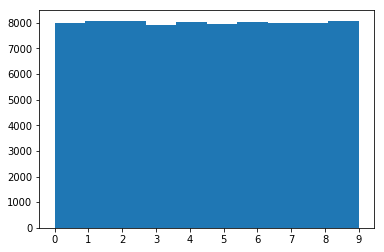

In [20]:
plt.hist(samples)
plt.xticks(range(x.numel()))
plt.show()

In [21]:
k = 2
samples = []
for _ in range(10000):
    samples.extend(reservoir_sampling(x, k).numpy())

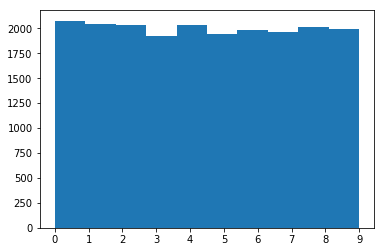

In [22]:
plt.hist(samples)
plt.xticks(range(x.numel()))
plt.show()